In [1]:
import sys
sys.path.insert(1, '../')
#
import math
import numpy as np              # scientific computing tools
import wrappers                 # for compilation of Fortran Hamiltonian codes
import geometry2d.database
import geometry2d.conjugate
import geometry2d.errors
import geometry2d.geodesic
import geometry2d.plottings
import geometry2d.problem
import geometry2d.splitting
import geometry2d.utils
import geometry2d.wavefront
import geometry2d.sphere
import nutopy as nt
import scipy
import matplotlib.pyplot as plt # for plots
%matplotlib inline

In [2]:
#
color_hyperbolic_2D = 'red'
color_hyperbolic_3D = (1.0, 0.2, 0.2)
color_elliptic_2D = 'blue'
color_elliptic_3D = (0.2, 0.2, 1.0)
color_abnormal_2D = (0.2, 0.8, 0.2) #'green'
color_abnormal_3D = (0.2, 1.0, 0.2)
color_cut_locus  = 'black'
color_conjugate  = 'magenta'
color_wavefront  = 'orange'
color_sphere     = 'orange'
#
color_strong_domain_2d = 'lightblue'
color_strong_domain_3d = 'black'
#
PLANE = geometry2d.plottings.Coords.PLANE
SPHERE = geometry2d.plottings.Coords.SPHERE

In [3]:
# print Fortran code of the Hamiltonian: print hfun.f90 file
with open('hfun.f90', 'r') as f:
    print(f.read())

! Landau
subroutine hfun(x, p, c, h)

    double precision, intent(in)  :: x(2), p(2), c(2)
    double precision, intent(out) :: h

    ! local variables
    double precision :: r, th, pr, pth
    double precision :: alpha, delta, beta, nu1, nu2, mu1, mu2, m2

    r   = x(1)
    th  = x(2)

    pr  = p(1)
    pth = p(2)

    alpha = c(1)
    delta = c(2)

    beta = delta*cos(r)
    nu1  = -alpha*sin(r)
    nu2  = 1d0
    mu1  = beta*nu1
    mu2  = beta*nu2

    m2   = sin(r)**2

    h   = mu1*pr + mu2*pth + sqrt(pr**2 + pth**2/m2)

end subroutine hfun


In [4]:
def m2(r):
    return np.sin(r)**2

def g2_Landau(r):
    return m2(r)

def initialize(c, r0):

    # Parameters
    θ0 = 0.0        # initial latitude
    t0 = 0.0        # initial time

    name = 'landau' # name of the problem

    # Initialize data
    data_file = 'data_landau.json'
    restart   = False # restart or not the computations
    data      = geometry2d.database.Data({'name': name,
                        't0': t0, 
                        'r0': r0, 
                        'θ0': θ0, 
                        'c': c}, data_file, restart)

    # Initial point
    q0 = np.array([r0, θ0])

    # Hamiltonian and derivatives up to order 3
    H = wrappers.hamiltonian(c, compile=False, display=False)

    # The Riemannian metric associated to the Zermelo problem
    # g = g1 dr^2 + g2 dθ^2
    def g(q):
        #λ  = 4.0/5.0
        r  = q[0] 
        g1 = 1.0
        g2 = g2_Landau(r)
        return g1, g2

    # problem
    prob = geometry2d.problem.GeometryProblem2D(name, H, g, t0, q0, data, steps_for_geodesics=500)
    
    return prob

## Domain of strong current

In [5]:
def K_fun(alpha, delta):
    return delta**2*(1+alpha**2)/4.0

def domain_strong_current(alpha, delta):
    #
    K = K_fun(alpha, delta)
    
    # North hemisphere
    rp1 = math.asin(1/np.sqrt(K))/2.0
    rp2 = (math.pi - math.asin(1/np.sqrt(K))) / 2.0

    # South hemisphere
    rm1 = (-math.asin(1/np.sqrt(K)) % (2*np.pi) )/2.0
    rm2 = (math.pi + math.asin(1/np.sqrt(K))) / 2.0
    
    return rp1, rp2, rm1, rm2

In [6]:
def update_2d_plot(fig):
    ax = fig.axes[0]
    # add vertical lines
    ax.axvline(2*np.pi, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
    ax.axvline(1*np.pi, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
    # set ylabel to "r" 
    ax.set_ylabel(r'$r$', rotation=0, labelpad=10)
    # set yticks: 0 => \pi/2, pi/2 => \pi, -pi/2 => 0
    ax.set_yticks([-np.pi/2, 0.0, np.pi/2])
    ax.set_yticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    # set xticks: 0, pi and 2pi
    ax.set_xticks([-np.pi, 0.0, np.pi, 2*np.pi])
    ax.set_xticklabels([r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'])
    # set xlims
    #ax.set_xlim(-1*np.pi/3, 2*np.pi + 1*np.pi/3)
    ax.set_xlim(-np.pi, np.pi)
    return fig

## Case without barrier

In [7]:
alpha_Landau = 1.9 # 1.9: no barrier, 2.0: barrier at pi/4, 2.1: two barriers around pi/4
delta_Landau = 1.0 # gamma2-gamma1

K = K_fun(alpha_Landau, delta_Landau)

if K <= 1:
    raise ValueError('K should be > 1')

r0       = np.pi/2.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)
rp1_strong, rp2_strong, rm1_strong, rm2_strong = domain_strong_current(alpha_Landau, delta_Landau)

#

αspan = np.linspace(0, 2*np.pi, 10)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -20}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

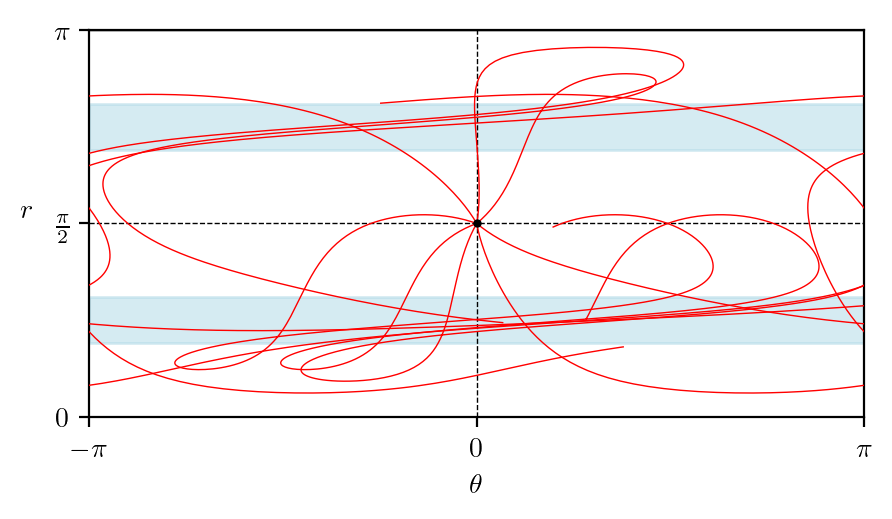

In [8]:
fig2d

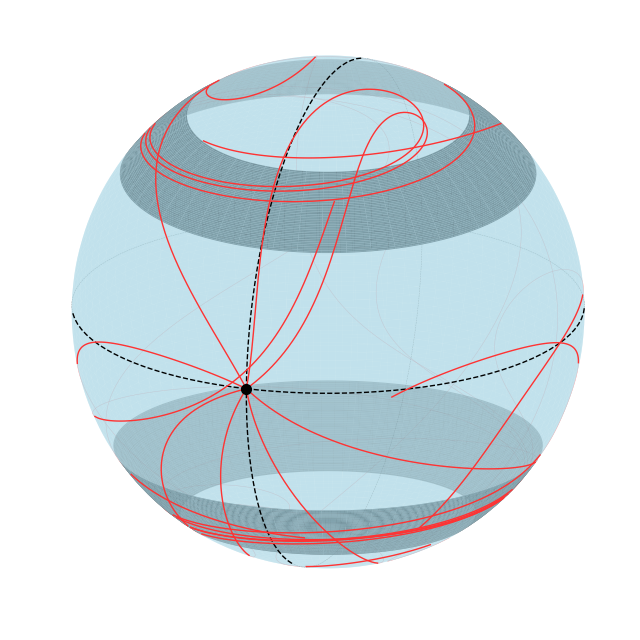

In [9]:
figs3d[0]

In [10]:
r0       = np.pi/2.0+np.pi/4.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)

#

αspan = np.linspace(0, 2*np.pi, 10)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -30}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

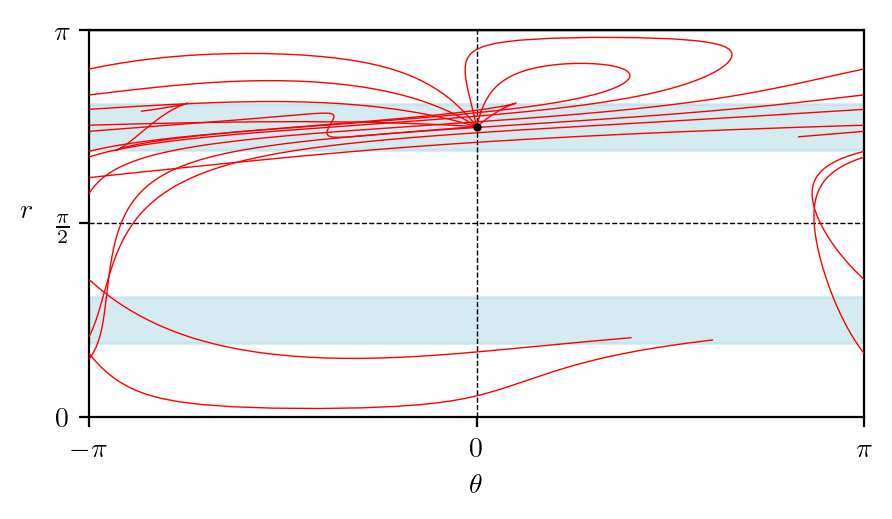

In [11]:
fig2d

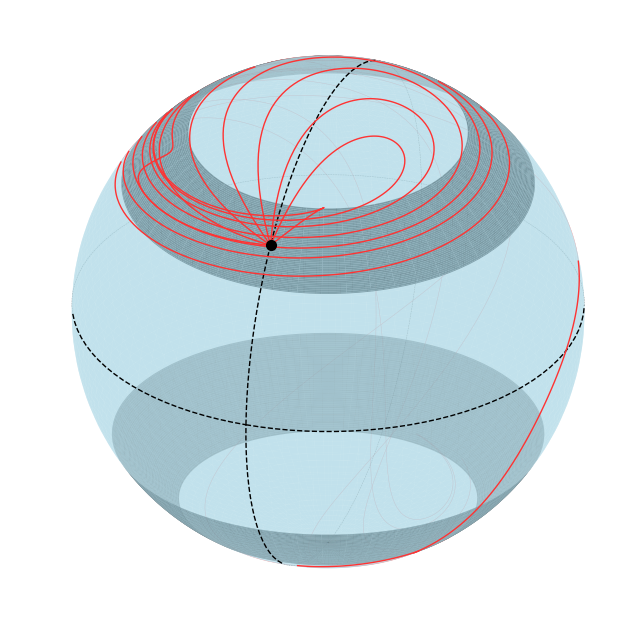

In [12]:
figs3d[0]

In [13]:
r0       = np.pi/2.0+np.pi/4.0+np.pi/8.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)

#

αspan = np.linspace(0, 2*np.pi, 10)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -30}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

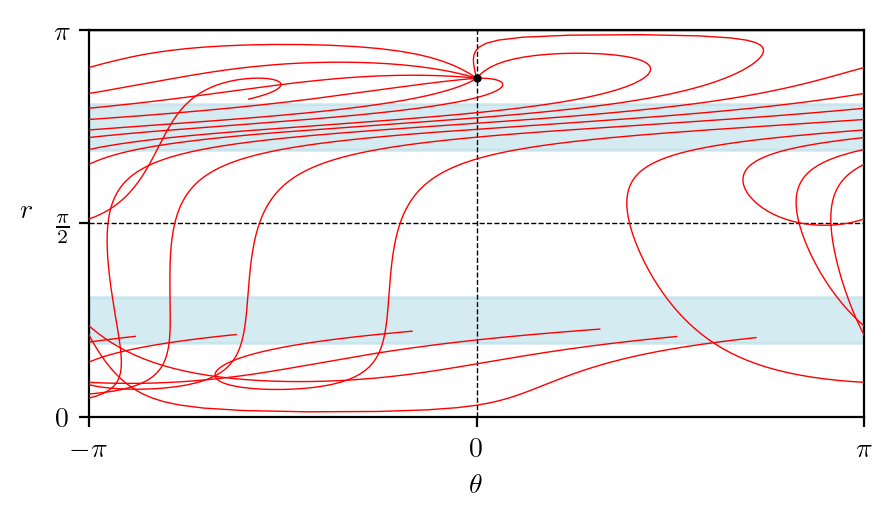

In [14]:
fig2d

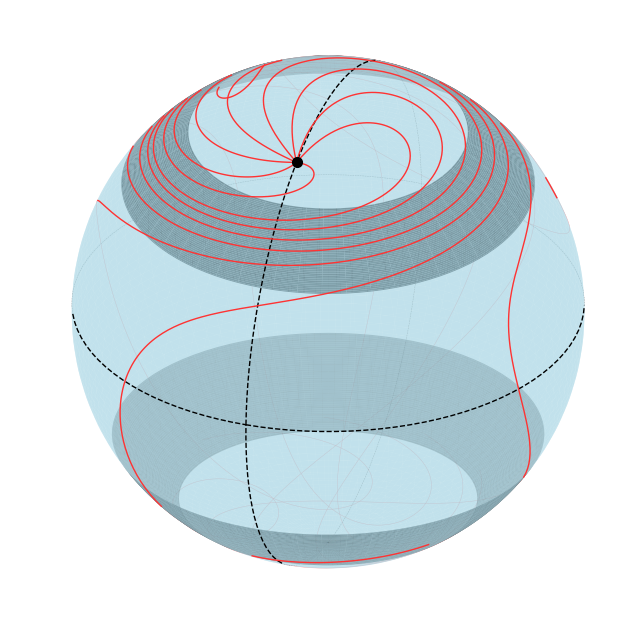

In [15]:
figs3d[0]

In [16]:
alpha_Landau = 1.8 # 1.9: no barrier, 2.0: barrier at pi/4, 2.1: two barriers around pi/4
delta_Landau = 1.0 # gamma2-gamma1

K = K_fun(alpha_Landau, delta_Landau)

if K <= 1:
    raise ValueError('K should be > 1')

r0       = np.pi/2.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)
rp1_strong, rp2_strong, rm1_strong, rm2_strong = domain_strong_current(alpha_Landau, delta_Landau)

#

αspan = np.linspace(0, 2*np.pi, 10)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -20}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

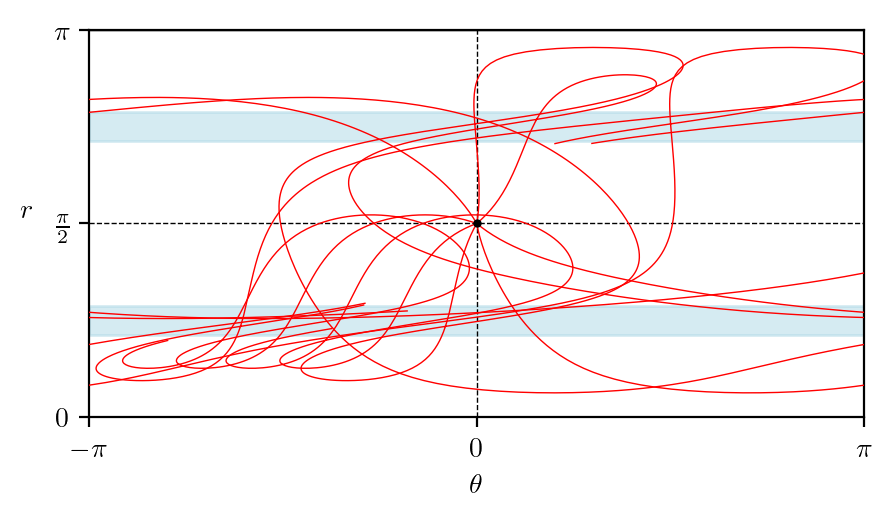

In [17]:
fig2d

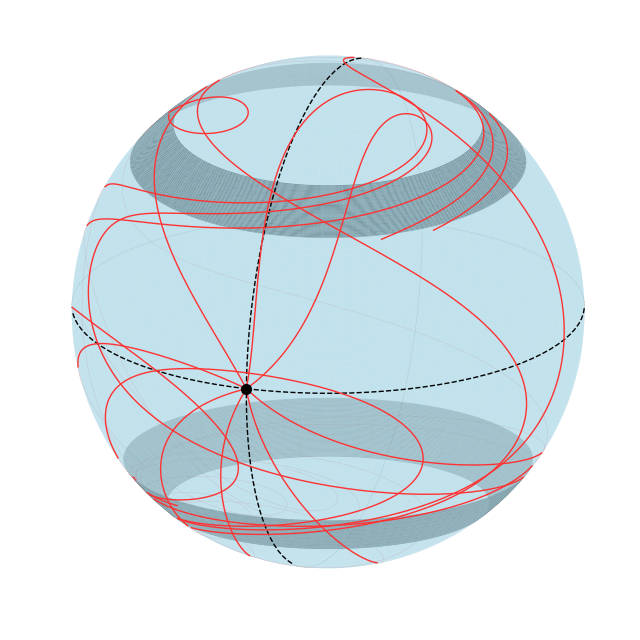

In [18]:
figs3d[0]

In [19]:
r0       = np.pi/2.0+np.pi/4.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)

#

αspan = np.linspace(0, 2*np.pi, 10)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -30}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

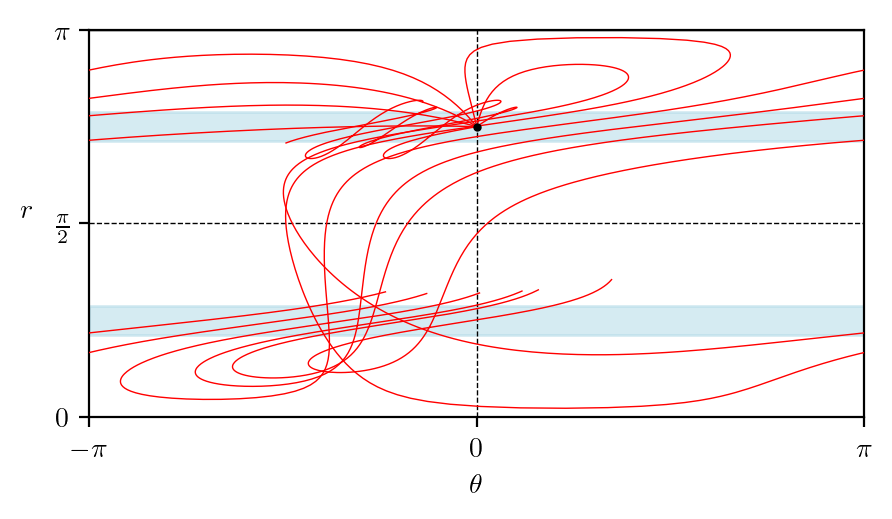

In [20]:
fig2d

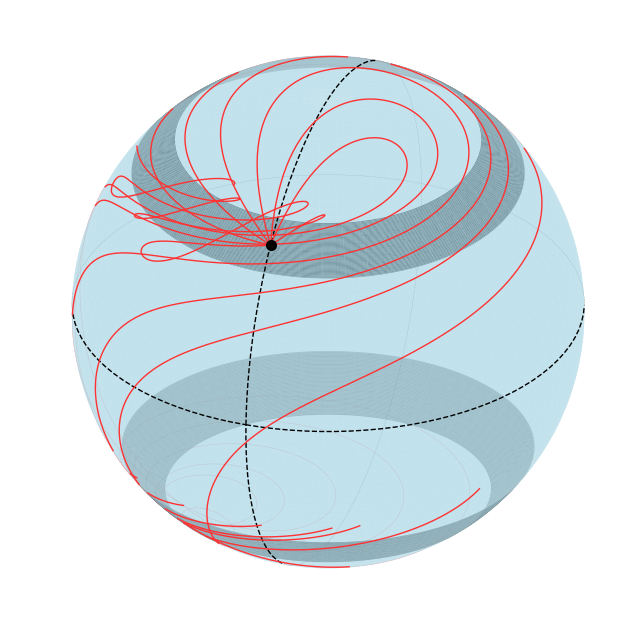

In [21]:
figs3d[0]

In [22]:
r0       = np.pi/2.0+np.pi/4.0+np.pi/8.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)

#

αspan = np.linspace(0, 2*np.pi, 10)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -30}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

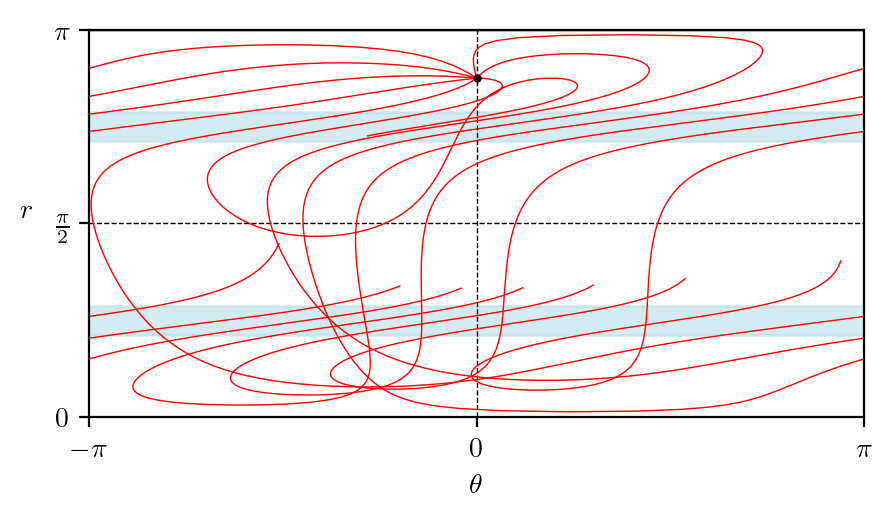

In [23]:
fig2d

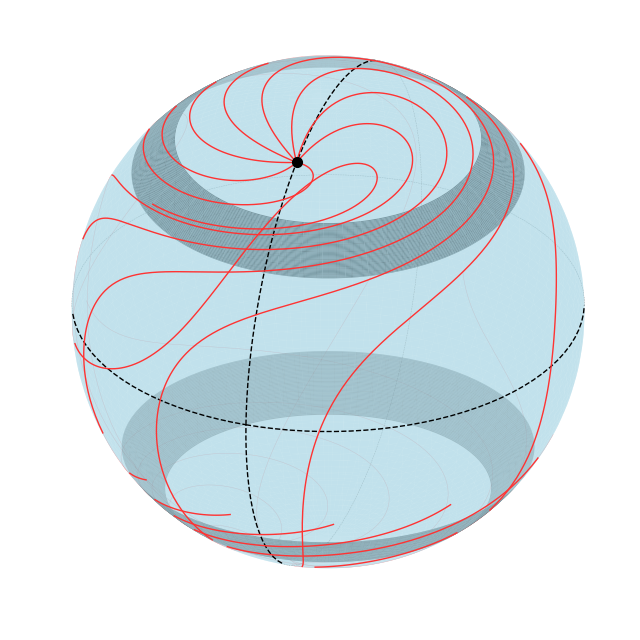

In [24]:
figs3d[0]

## Case with barrier

In [25]:
alpha_Landau = 2.1 # 1.9: no barrier, 2.0: barrier at pi/4, 2.1: two barriers around pi/4
delta_Landau = 1.0 # gamma2-gamma1

K = K_fun(alpha_Landau, delta_Landau)

if K <= 1:
    raise ValueError('K should be > 1')

r0       = np.pi/2.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)
rp1_strong, rp2_strong, rm1_strong, rm2_strong = domain_strong_current(alpha_Landau, delta_Landau)

#

αspan = np.linspace(0, 2*np.pi, 20)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -20}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

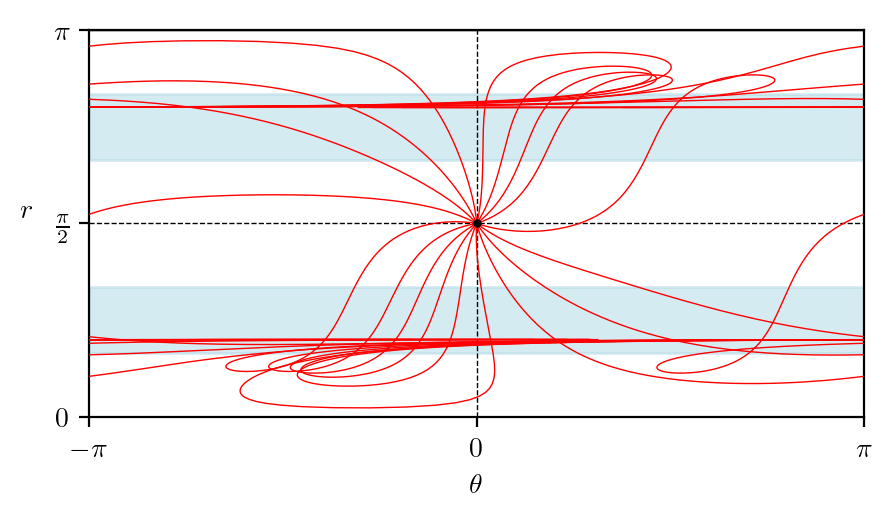

In [26]:
fig2d

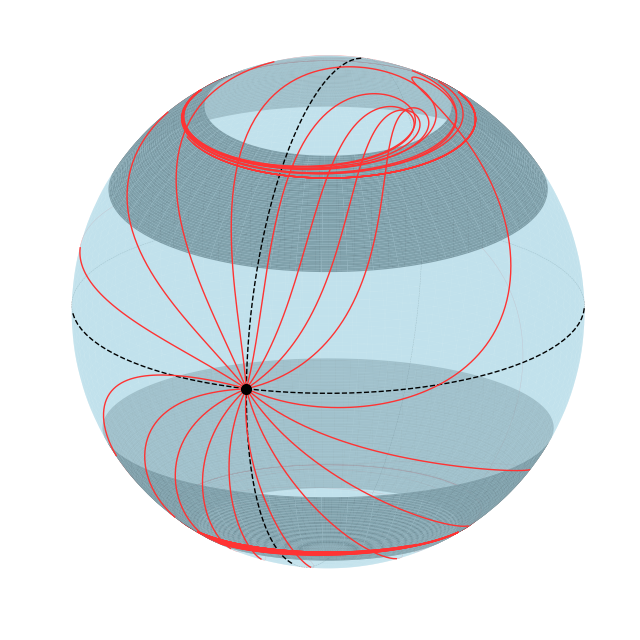

In [27]:
figs3d[0]

In [28]:
r0       = np.pi/2.0 + np.pi/4.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)

#

αspan = np.linspace(0, 2*np.pi, 20)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -30}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

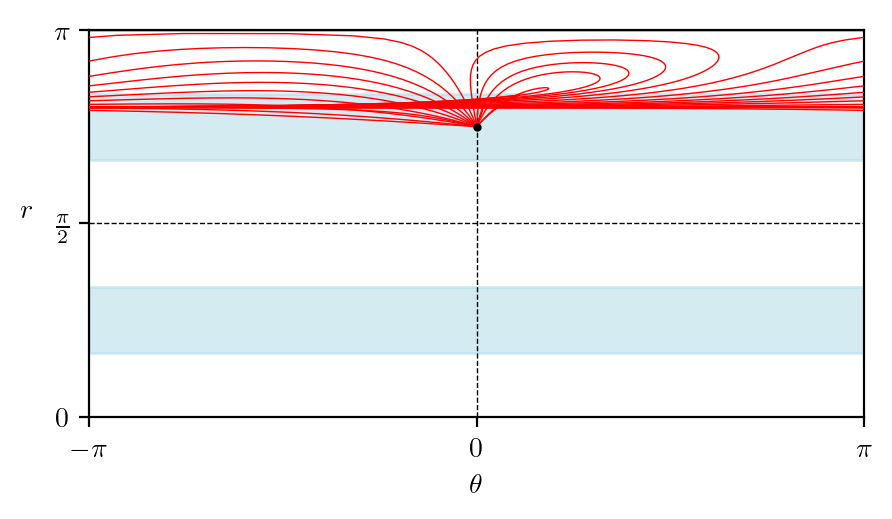

In [29]:
fig2d

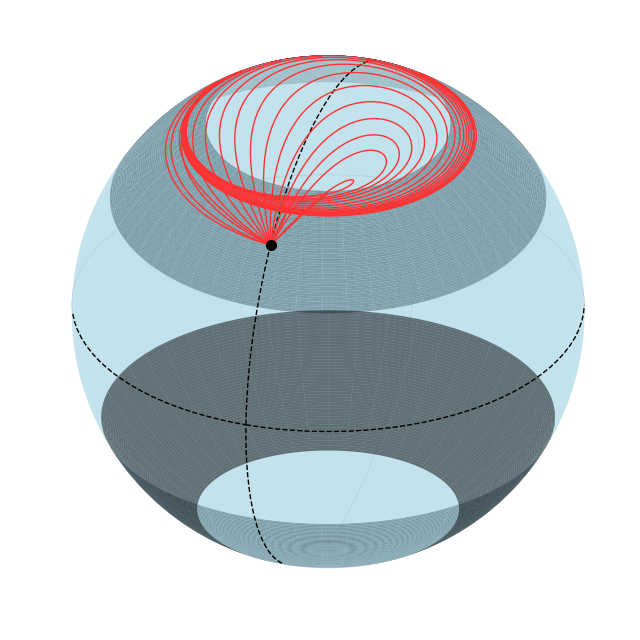

In [30]:
figs3d[0]

In [31]:
r0       = np.pi/2.0 + np.pi/4.0 + np.pi/8.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)

#

αspan = np.linspace(0, 2*np.pi, 20)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -30}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

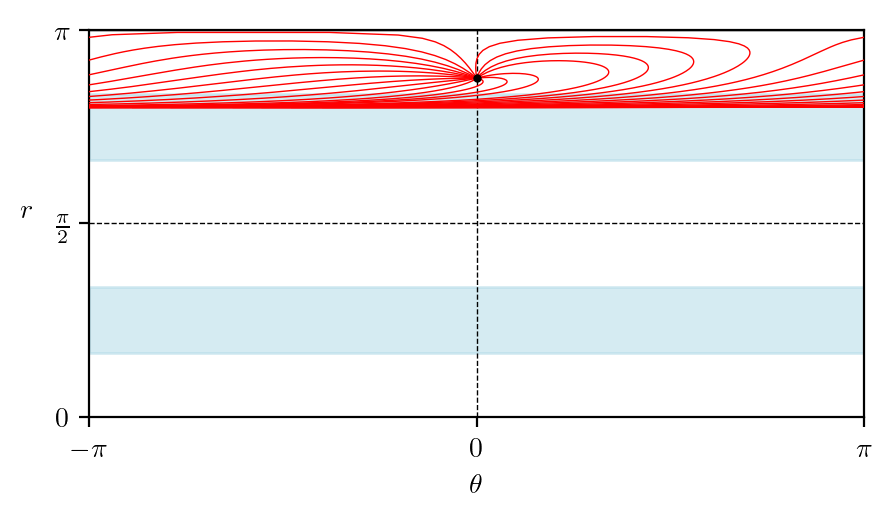

In [32]:
fig2d

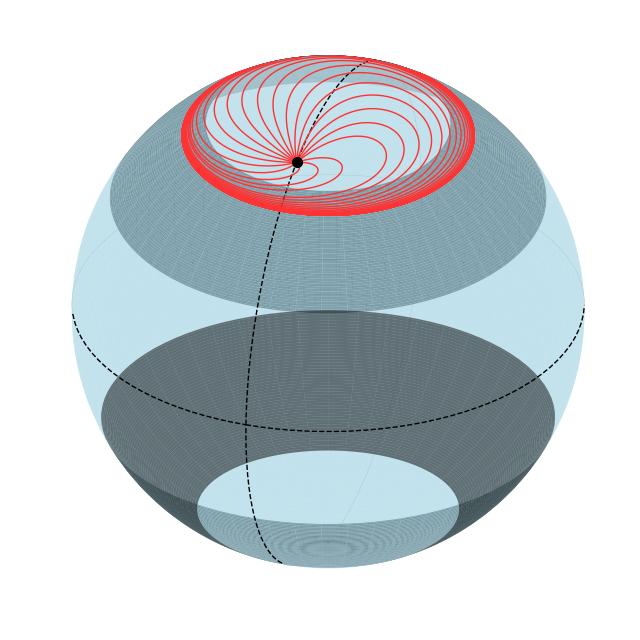

In [33]:
figs3d[0]

In [34]:
alpha_Landau = 2.3 # 1.9: no barrier, 2.0: barrier at pi/4, 2.1: two barriers around pi/4
delta_Landau = 1.0 # gamma2-gamma1

K = K_fun(alpha_Landau, delta_Landau)

if K <= 1:
    raise ValueError('K should be > 1')

r0       = np.pi/2.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)
rp1_strong, rp2_strong, rm1_strong, rm2_strong = domain_strong_current(alpha_Landau, delta_Landau)

#

αspan = np.linspace(0, 2*np.pi, 20)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -20}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

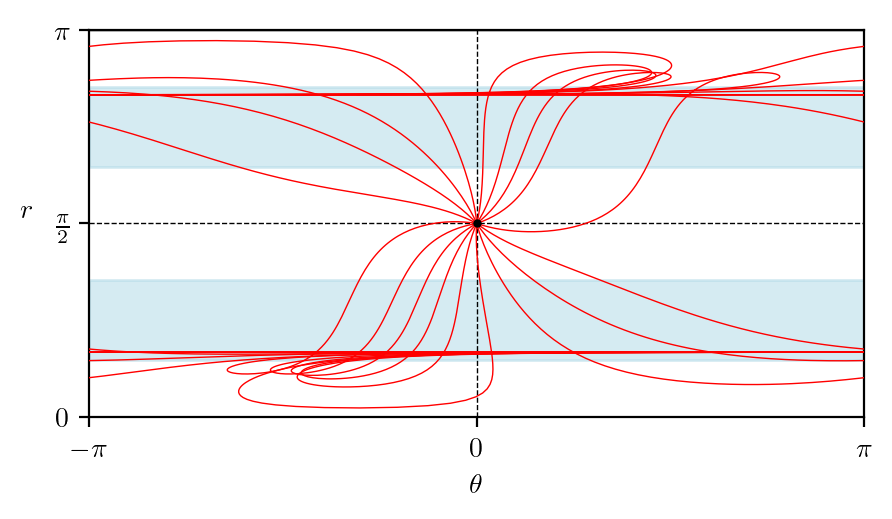

In [35]:
fig2d

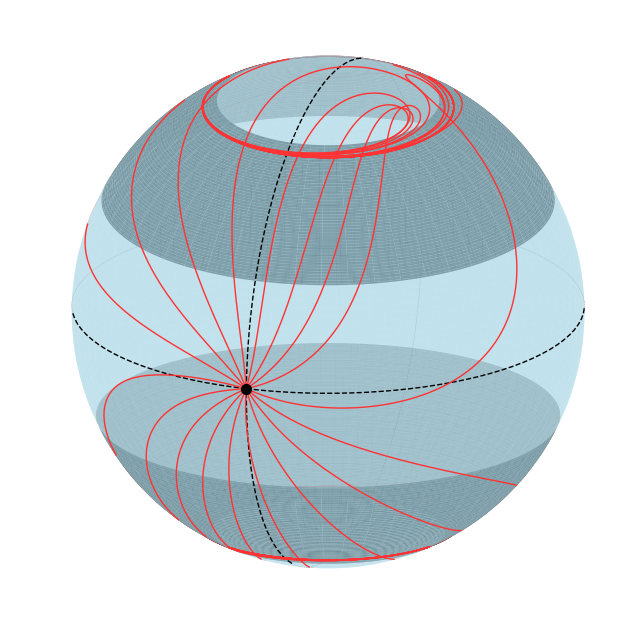

In [36]:
figs3d[0]

In [37]:
r0       = np.pi/2.0 + np.pi/4.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)

#

αspan = np.linspace(0, 2*np.pi, 20)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -30}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

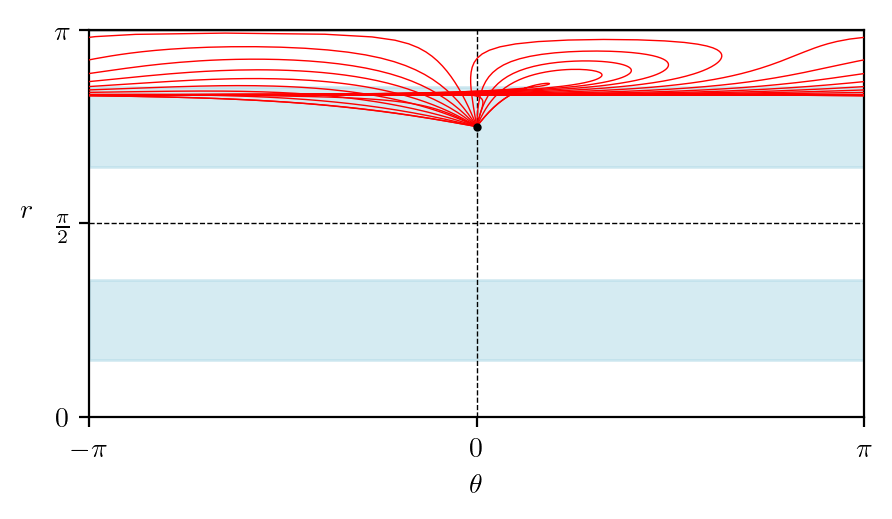

In [38]:
fig2d

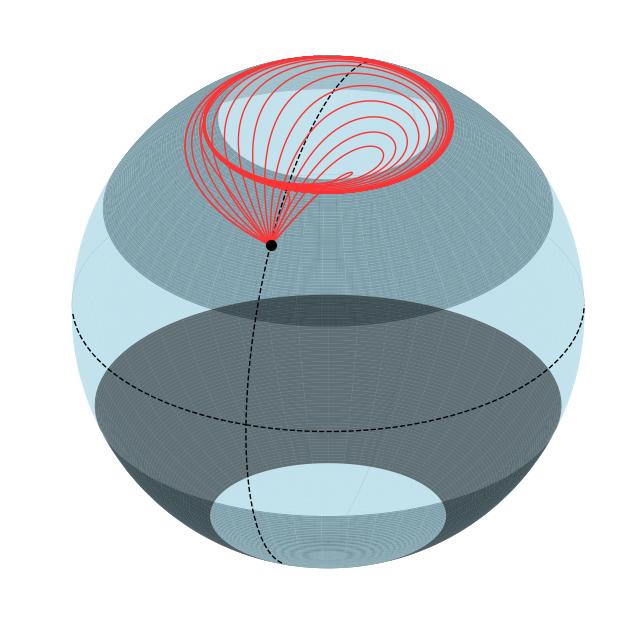

In [39]:
figs3d[0] 

In [40]:
r0       = np.pi/2.0 + np.pi/4.0 + np.pi/8.0
prob     = initialize([alpha_Landau, delta_Landau], r0)
geodesic = geometry2d.geodesic.Geodesic(prob)

#

αspan = np.linspace(0, 2*np.pi, 20)
tf = 4*np.pi

#
fig2d = geodesic.plot(alphas=αspan, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic_2D)
fig2d = update_2d_plot(fig2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rp1_strong, rp2_strong, color_strong_domain_2d)
fig2d = geometry2d.utils.plot_2d_domain(fig2d, rm1_strong, rm2_strong, color_strong_domain_2d)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 160, 'elevation': -30}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan, tf=tf, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_hyperbolic_3D)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rp1_strong, rp2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    fig3d = geometry2d.utils.plot_3d_domain(fig3d, rm1_strong, rm2_strong, color_strong_domain_3d, azimuth=azimuth, elevation=elevation)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

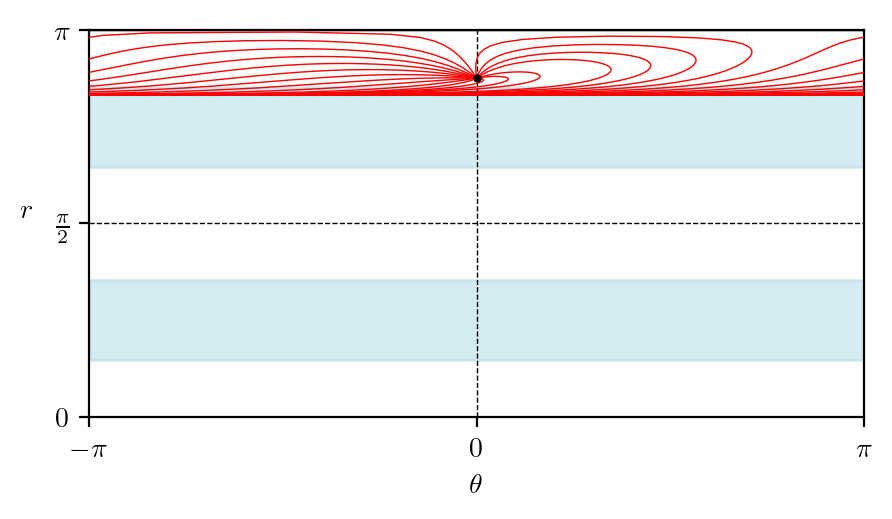

In [41]:
fig2d

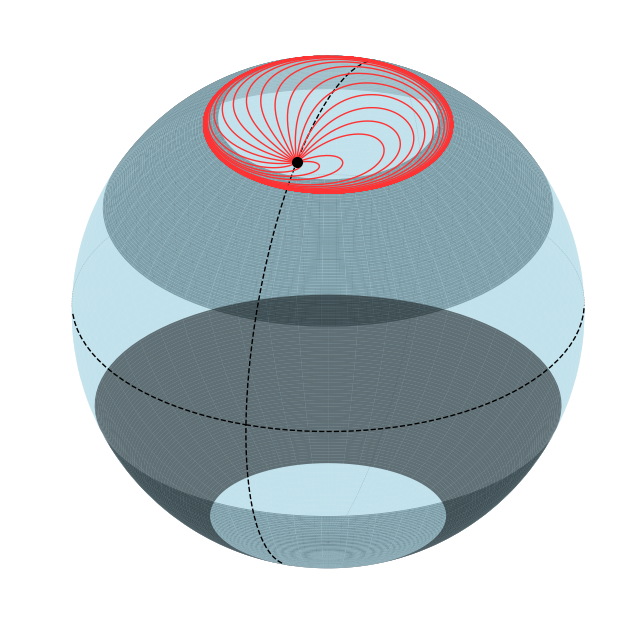

In [42]:
figs3d[0]